In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso


Load Data

In [2]:
# Load the transaction data
df1 = pd.read_csv('updated_fraud_transactions.csv')


In [3]:
#load customer data
df2 = pd.read_csv('customer_dataset 1.csv')


In [5]:
# Merge the datasets
df = pd.merge(df1, df2, left_on='Sender Account ID', right_on='Customer ID')


Data Exploration & Preprocessing

In [6]:
# Display basic information
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Transaction ID     100000 non-null  object 
 1   Timestamp          100000 non-null  object 
 2   Sender Account ID  100000 non-null  int64  
 3   Transaction Type   100000 non-null  object 
 4   IN_OUT             100000 non-null  object 
 5   Amount             100000 non-null  float64
 6   Recipient Bank     100000 non-null  object 
 7   Fraud              100000 non-null  int64  
 8   Customer ID        100000 non-null  int64  
 9   Name               100000 non-null  object 
 10  Age                100000 non-null  int64  
 11  Location           100000 non-null  object 
 12  Gender             100000 non-null  object 
 13  Account Type       100000 non-null  object 
 14  Device Count       100000 non-null  int64  
dtypes: float64(1), int64(5), object(9)
memory usage: 11.

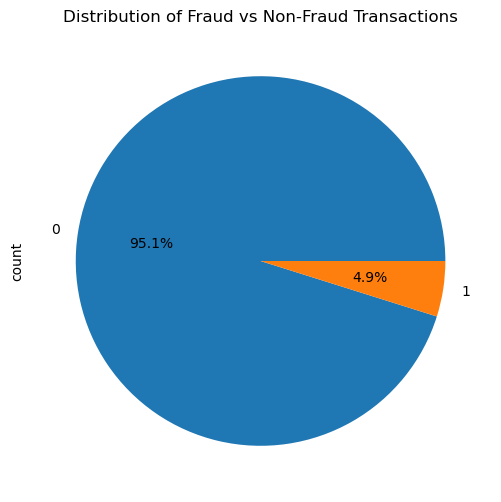

In [7]:
# Visualize fraud distribution
plt.figure(figsize=(8, 6))
df['Fraud'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

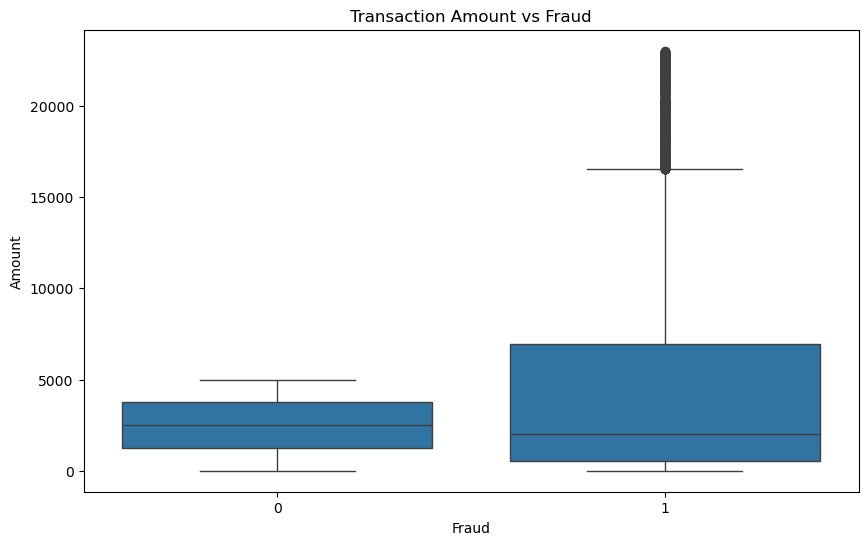

In [8]:
# Visualize transaction amount vs fraud
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fraud', y='Amount', data=df)
plt.title('Transaction Amount vs Fraud')
plt.show()

Feature Engineering

In [9]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


In [10]:
# Time-based features
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)


In [11]:
# Amount-based features
df['Amount_Log'] = np.log1p(df['Amount'])
df['Amount_Bin'] = pd.qcut(df['Amount'], q=10, labels=False)


In [12]:
# Customer behavior features
customer_avg_amount = df.groupby('Sender Account ID')['Amount'].mean().reset_index()
customer_avg_amount.columns = ['Sender Account ID', 'Avg_Amount']
df = pd.merge(df, customer_avg_amount, on='Sender Account ID', how='left')
df['Amount_to_Avg_Ratio'] = df['Amount'] / df['Avg_Amount']

transaction_count = df.groupby('Sender Account ID').size().reset_index(name='Transaction_Count')
df = pd.merge(df, transaction_count, on='Sender Account ID', how='left')


In [13]:
# Recency feature
df['Last_Transaction'] = df.groupby('Sender Account ID')['Timestamp'].shift(1)
df['Time_Since_Last_Transaction'] = (df['Timestamp'] - df['Last_Transaction']).dt.total_seconds() / 3600


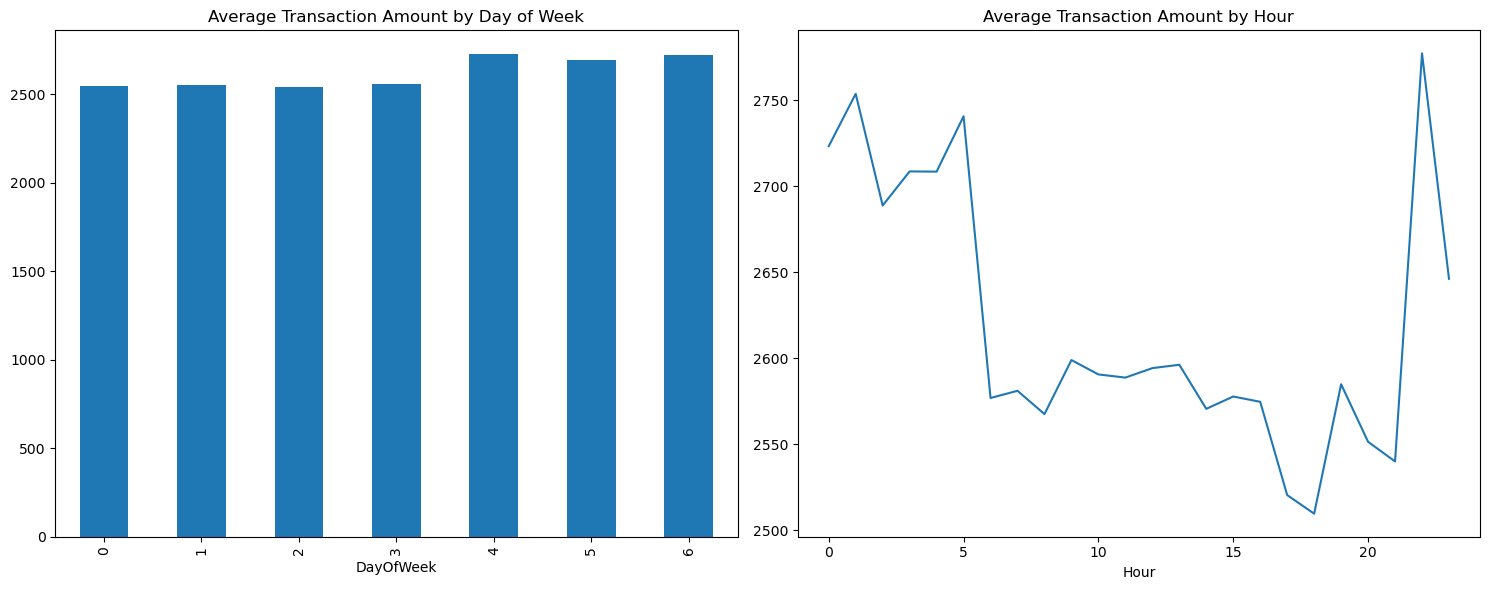

In [14]:
# Visualization: Transaction history structure
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
df.groupby('DayOfWeek')['Amount'].mean().plot(kind='bar')
plt.title('Average Transaction Amount by Day of Week')
plt.subplot(1, 2, 2)
df.groupby('Hour')['Amount'].mean().plot(kind='line')
plt.title('Average Transaction Amount by Hour')
plt.tight_layout()
plt.show()

Preprocessing

In [18]:
categorical_cols = ['Transaction Type', 'IN_OUT', 'Recipient Bank', 'Account Type', 'Gender', 'Location']

# One-hot encoding for categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categorical_cols])

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
# Get feature names
if hasattr(encoder, 'get_feature_names_out'):
    # For newer scikit-learn versions
    feature_names = encoder.get_feature_names_out(categorical_cols)
else:
    # For older scikit-learn versions
    feature_names = encoder.get_feature_names(categorical_cols)

# Create DataFrame with encoded variables
encoded_df = pd.DataFrame(encoded_cats, columns=feature_names)


In [21]:
# Combine numerical and encoded categorical features
numerical_cols = ['Amount', 'Amount_Log', 'Amount_Bin', 'Hour', 'Day', 'Month', 'DayOfWeek', 'IsWeekend',
                  'Avg_Amount', 'Amount_to_Avg_Ratio', 'Transaction_Count', 'Time_Since_Last_Transaction',
                  'Age', 'Device Count']
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Fraud']


In [22]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

Normalization

In [23]:
# Using StandardScaler for normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled, columns=X_imputed.columns)


Feature Selection

In [24]:
# Using Lasso for feature selection
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)
feature_importance = pd.Series(np.abs(lasso.coef_), index=X_scaled.columns).sort_values(ascending=False)


In [25]:
# Select top 20 features
selected_features = feature_importance.head(20).index.tolist()
X_selected = X_scaled[selected_features]

In [26]:
print("Top 20 selected features:", selected_features)


Top 20 selected features: ['Amount', 'Gender_Male', 'Recipient Bank_B0005', 'Recipient Bank_B0006', 'Recipient Bank_B0007', 'Recipient Bank_B0008', 'Recipient Bank_B0009', 'Account Type_Current', 'Account Type_Fixed Deposit', 'Account Type_Savings', 'Gender_Female', 'Gender_Other', 'Amount_Log', 'Location_Anuradhapura', 'Location_Batticaloa', 'Location_Colombo', 'Location_Galle', 'Location_Jaffna', 'Location_Kandy', 'Location_Matara']


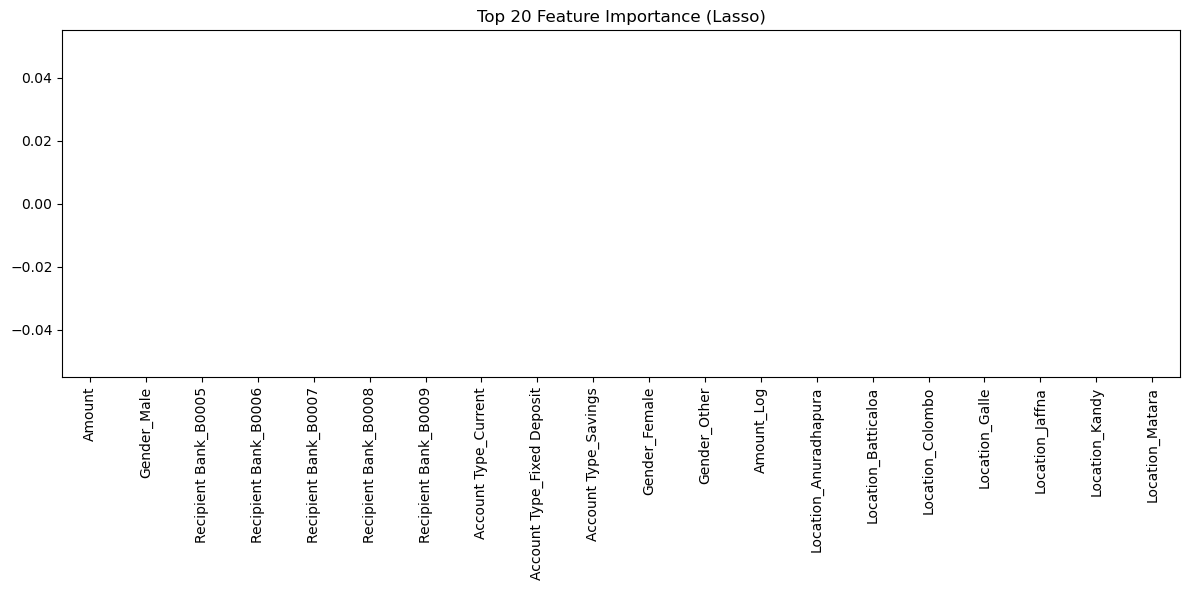

In [27]:
# Visualization of feature importance
plt.figure(figsize=(12, 6))
feature_importance.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importance (Lasso)')
plt.tight_layout()
plt.show()

Dimensionality Reduction

In [28]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_selected)
print(f"Number of components after PCA: {pca.n_components_}")


Number of components after PCA: 16


Data Balancing

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [30]:
print("Class distribution before balancing:")
print(pd.Series(y_train).value_counts(normalize=True))


Class distribution before balancing:
Fraud
0    0.951425
1    0.048575
Name: proportion, dtype: float64


In [31]:
# Oversampling with SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust minority class to be 50% of majority
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)


In [32]:
# Undersampling
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Keep 70% of majority class
X_train_balanced, y_train_balanced = under.fit_resample(X_train_over, y_train_over)


In [33]:
print("Class distribution after balancing:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))


Class distribution after balancing:
Fraud
0    0.588235
1    0.411765
Name: proportion, dtype: float64
